# Bubble Plot

In [15]:
import pandas as pd
data = pd.read_excel("../0_dataset_master/Experiment_edited_V7_rr_with_correction.xlsx")

In [16]:
data = data.sort_values(by='SET', ascending=True)

R-squared: 0.9686419969467881
Formula: y = 0.0 + -2.289168981891076 x + 0.2535741431231741 x^2 + -0.009024459648073862 x^3 + 0.0001043286384880826 x^4


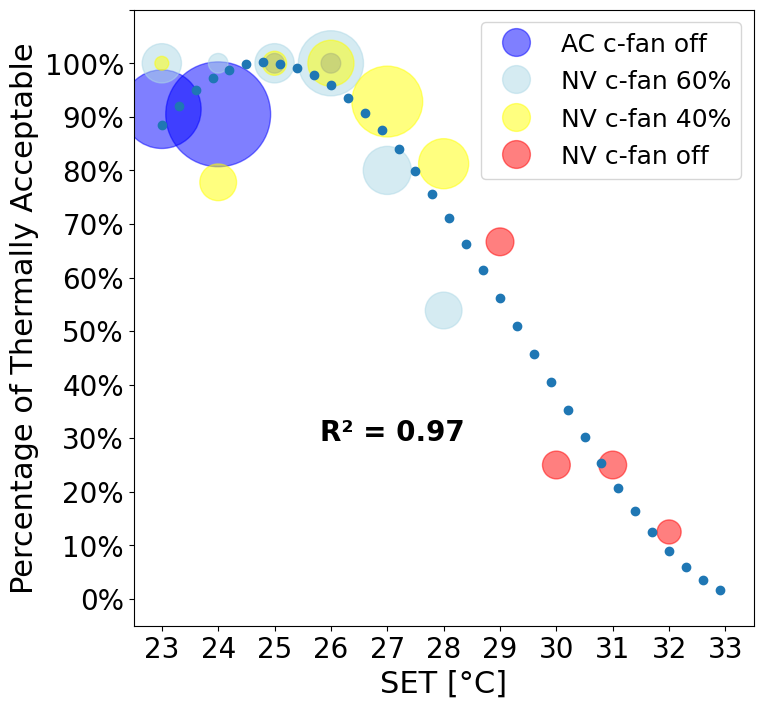

In [17]:
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
import matplotlib.pyplot as plt
from collections import Counter
from matplotlib.lines import Line2D
from sklearn.pipeline import Pipeline

plt.figure(figsize=(8, 8))

colorMap = {
    'AC':"#0000FF",
    'NV fan 5':"#ADD8E6",
    'NV fan 3':"#FFFF00", 
    'NV fan 0':"#FF0000"
}
labels = {
    'AC':"AC c-fan off",
    'NV fan 5':"NV c-fan 60%",
    'NV fan 3':"NV c-fan 40%", 
    'NV fan 0':"NV c-fan off"
}

custom_handles = []
custom_labels = []
# bubble plot process
for thermalType in colorMap.keys():
    dataFilteredByThermalType = data[data['Thermal']==thermalType].copy()
    Y = dataFilteredByThermalType['ThermalAcceptability'].copy()
    x_list = np.floor(dataFilteredByThermalType['SET']).astype(int).values.copy()
    coordinates = list(zip(x_list, Y))
    counts = Counter(coordinates)
    # Extract x, y, and size data
    x = [coord[0] for coord in counts.keys()]
    y = [coord[1] for coord in counts.keys()]
    sizes = [count for count in counts.values()]

    # Sample DataFrame
    dict_data = {
        'x': x,
        'y': y,
        'size': sizes
    }
    df = pd.DataFrame(dict_data)

    # Define custom aggregation function
    def custom_agg(x):
        return pd.Series({'y': x[x['y']>=3]['size'].sum()/x['size'].sum(), 'size': x[x['y']>=3]['size'].sum()*100})
    
    # Grouping by 'x' and aggregating y and size
    grouped_df = df.groupby('x').apply(custom_agg).reset_index()
    # Plotting the bubble plot
    plt.scatter(grouped_df['x'], grouped_df['y'], s=grouped_df['size'], alpha=0.5, c=colorMap[thermalType])
    custom_handles.append(
       Line2D([0], [0], marker='o', color=colorMap[thermalType], markersize=20, alpha=0.5, linewidth=0)
    )
    custom_labels.append(
       labels[thermalType]
    )


Y = data['ThermalAcceptability'].copy()
X = np.floor(data['SET']).astype(int).copy()

coordinates = list(zip(X, Y))
counts = Counter(coordinates)
# Extract x, y, and size data
x = [coord[0] for coord in counts.keys()]
y = [coord[1] for coord in counts.keys()]
sizes = [count for count in counts.values()]

# Sample DataFrame
dict_data = {
    'x': x,
    'y': y,
    'size': sizes
}
df = pd.DataFrame(dict_data)

# Define custom aggregation function
def custom_agg(x):
    return pd.Series({'y': x[x['y']>=3]['size'].sum()/x['size'].sum(), 'size': x[x['y']>=3]['size'].sum()*100})

# Grouping by 'x' and aggregating y and size
grouped_df = df.groupby('x').apply(custom_agg).reset_index()

# regression code
poly_features = Pipeline([('poly', PolynomialFeatures(degree=4, include_bias=False)),
                  ('linear', LinearRegression(fit_intercept=False))])
poly_features.fit(grouped_df['x'].values.reshape(-1,1),grouped_df['y'].values.reshape(-1,1))
r_squared = poly_features.score(grouped_df['x'].values.reshape(-1,1),grouped_df['y'].values.reshape(-1,1))

# Get formula
intercept = poly_features.named_steps['linear'].intercept_
coefficients = poly_features.named_steps['linear'].coef_

# Print R-squared value and formula
print("R-squared:", r_squared)
print("Formula: y =", intercept, "+", coefficients[0][0], "x +", coefficients[0][1], "x^2 +", coefficients[0][2], "x^3 +", coefficients[0][3], "x^4")

# reg plot
x_pred = np.arange(grouped_df.x.min(), grouped_df.x.max(), 0.3)
plt.scatter(x_pred.reshape(-1,1), poly_features.predict(x_pred.reshape(-1,1)))
plt.xticks(np.arange(data.SET.astype(int).min(), data.SET.max(), 1), fontsize=20)
plt.yticks(np.arange(0, 1.2, 0.1), ['0%','10%', '20%', '30%', '40%', '50%', '60%', '70%', '80%', '90%', '100%', ''], fontsize=20)
plt.xlabel('SET [°C]', fontsize=22)  # Set x-axis title
plt.ylabel('Percentage of Thermally Acceptable', fontsize=22)  # Set y-axis title
plt.text(.3, .3, f'R² = {r_squared:.2f}', transform=plt.gca().transAxes, fontsize=20, fontweight='bold')
plt.legend(custom_handles, custom_labels, handleheight=1, fontsize=18)
plt.show() 

# ASHRAE Plot

In [18]:
import pythermalcomfort.models as ptc
import pandas as pd
outdoorTemp = pd.read_csv("../0_dataset_master/bcaa_weather_0425_0929_updated.csv")
masterDataAshrae = pd.read_excel("../0_dataset_master/Experiment_edited_V8.xlsx")

In [19]:
outdoorTemp['Date'] = pd.to_datetime(outdoorTemp[' GMT+08:00'], format='%Y/%m/%d %H:%M')
outdoorTemp['Date_plus_5_minutes'] = outdoorTemp['Date'] + pd.Timedelta(minutes=5)

In [20]:
def getOutdoorTemp(x):
    return outdoorTemp[(outdoorTemp['Date']>=x['Start Date']) & (outdoorTemp['Date_plus_5_minutes']<=x['End Date'])]['Temperature (S-THC 21661173:21555952-1), *C, ideaslab'].mean()

masterDataAshrae['outdoorTemp'] = masterDataAshrae.apply(lambda row: getOutdoorTemp(row), axis=1)

In [21]:
import math
def calculateOperativeTemperature(row):
    return (row['T']*math.sqrt(10*row['v_adj'])+row['Tgl'])/(1+math.sqrt(10*row['v_adj']))

In [22]:
masterDataAshrae['tmp_cmf_80_low'] = masterDataAshrae.apply(lambda row: ptc.adaptive_ashrae(tdb = row['T'], tr=row['Tgl'], t_running_mean=row['outdoorTemp'], v=row['v_adj'])['tmp_cmf_80_low'], axis=1)
masterDataAshrae['tmp_cmf_80_up'] = masterDataAshrae.apply(lambda row: ptc.adaptive_ashrae(tdb = row['T'], tr=row['Tgl'], t_running_mean=row['outdoorTemp'], v=row['v_adj'])['tmp_cmf_80_up'], axis=1)
masterDataAshrae['operativeTemp'] = masterDataAshrae.apply(lambda row: calculateOperativeTemperature(row), axis=1)

In [23]:
masterDataAshrae.to_excel("../0_dataset_master/Experiment_edited_V9.xlsx", index=False)

Data before filtered: 306 rows
Data after filtered: 204 rows


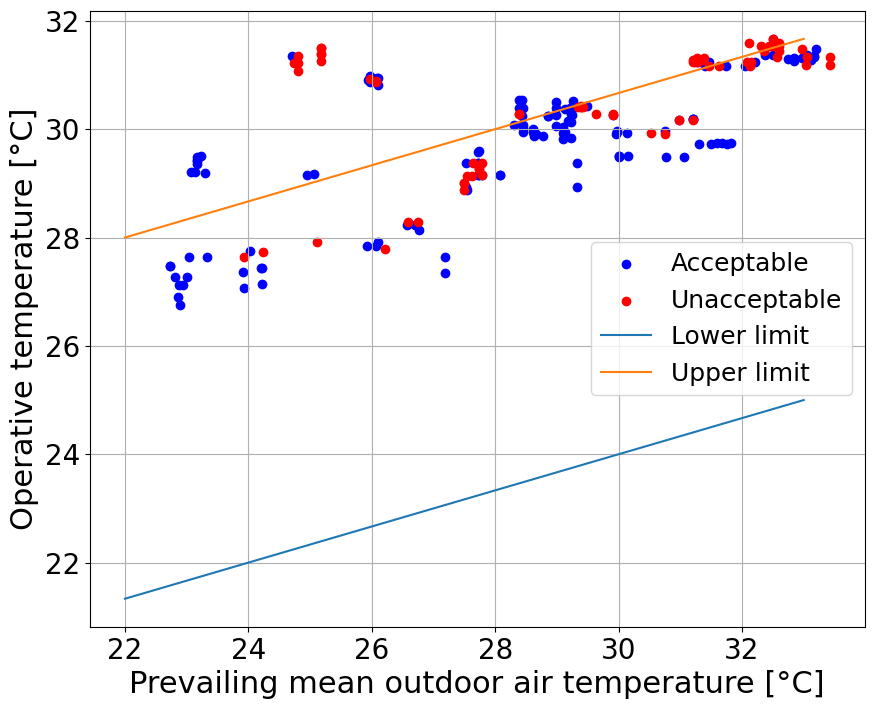

In [25]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

plt.figure(figsize=(10, 8))
plt.grid()

masterDataAshrae = masterDataAshrae.sort_values(by='outdoorTemp', ascending=False)
print(f"Data before filtered: {len(masterDataAshrae)} rows")
dataAshraeFiltered = masterDataAshrae[masterDataAshrae['Thermal']!="AC"]
print(f"Data after filtered: {len(dataAshraeFiltered)} rows")
for thermalAcc in ["Acceptable", "Unacceptable"]:
    if thermalAcc == "Acceptable":
        dataFilteredByThermalType = dataAshraeFiltered[(dataAshraeFiltered['ThermalAcceptability'] == 3) | (dataAshraeFiltered['ThermalAcceptability'] == 4)]
        Y = dataFilteredByThermalType['operativeTemp'].copy().values
        X = dataFilteredByThermalType['outdoorTemp'].copy().values
        plt.scatter(X,Y, c="b", label=thermalAcc)
    else:
        dataFilteredByThermalType = dataAshraeFiltered[(dataAshraeFiltered['ThermalAcceptability'] == 1) | (dataAshraeFiltered['ThermalAcceptability'] == 2)]
        Y = dataFilteredByThermalType['operativeTemp'].copy().values
        X = dataFilteredByThermalType['outdoorTemp'].copy().values
        plt.scatter(X,Y, c="r", label=thermalAcc)

X = np.array([12,18])
Y = np.array([18,20])
modelLower = LinearRegression()
modelLower.fit(X.reshape(-1,1), Y.reshape(-1,1))
plt.plot(np.floor(dataAshraeFiltered['outdoorTemp']).astype(int).copy().values.reshape(-1,1), modelLower.predict(np.floor(dataAshraeFiltered['outdoorTemp']).astype(int).copy().values.reshape(-1,1)), label="Lower limit")

X = np.array([22,28])
Y = np.array([28,30])
modelUpper = LinearRegression()
modelUpper.fit(X.reshape(-1,1), Y.reshape(-1,1))
plt.plot(np.floor(dataAshraeFiltered['outdoorTemp']).astype(int).copy().values.reshape(-1,1), modelUpper.predict(np.floor(dataAshraeFiltered['outdoorTemp']).astype(int).copy().values.reshape(-1,1)), label="Upper limit")

plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel('Prevailing mean outdoor air temperature [°C]', fontsize=22)  # Set x-axis title
plt.ylabel('Operative temperature [°C]', fontsize=22)  # Set y-axis title
plt.legend(fontsize=18)
plt.show() 